In [1]:
!conda install -c conda-forge yellowbrick -y
!conda install pandas-profiling -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



# Housing Prices Analysis & Prediction

## Problem Understanding: King County Housing Prices
![map of king county](king_county_map.jpeg)


## Objectives 
- Create a model to predict house prices in King County
- Said model should minimize root mean squared error

In [18]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import get_scorer
from sklearn.metrics.pairwise import haversine_distances
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.dummy import DummyRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import RadiusNeighborsClassifier


from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, HuberRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor


from yellowbrick.model_selection import learning_curve
from yellowbrick.regressor import residuals_plot

from pandas_profiling import ProfileReport

from typing import  List, Union, Tuple
Series = pd.core.frame.Series 
Figure = matplotlib.figure.Figure
Subplot = matplotlib.axes._subplots.Axes
%matplotlib inline
DataFrame = pd.core.frame.DataFrame # define type alias

## Loading Data

In [3]:
house_df = pd.read_csv("kc_house_data.csv")
house_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## Data Exploration

### Dataset Description
This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

### Dataset Dictionary
| Column | Data Type | Remarks |
|---|---|---|
| id | Integer (Nominal) | Unique ID for each house |
| date | Date | Need to convert to dt format from string |
| price | Float (Ratio) | Target Variable |
| bedrooms | Integer (Count) | No. of Bedrooms in the House |
| bathrooms | Float (Count) | Quarter of a bathroom is a bathroom with a toilet only, no shower |
| sqft_living | Float (Ratio) | Square footage of the inside of the house |
| sqft_lot | Float (Ratio) | Square footage of the entire home, including the exterior |
| floors | Float (Count) | Includes split level home|
| waterfront | Integer (Boolean) | Is the property a waterfront property? |
| view | Integer (Ordinal) | On a scale of 0 to 4, how good is the view of the property |
| condition | Integer (Ordinal) | On a scale of 1 to 5, how good is the condition of the house |
| grade | Integer (Ordinal) | On a scale of 1 to 13, how good is the quality of the house |
| sqft_above | Float (Ratio) | Square footage of the parts of the house above the first floor |
| sqft_basement | Float (Ratio) | Square footage of the basement of the house |
| yr_built | Integer (Interval) | Year of Construction |
| yr_renovated | Integer (Interval) | Year of latest renovation |
| zipcode | Integer (Nominal) | zipcode of house |
| lat | Float (Interval) | Latitude (North-South)|
| long | Float (Interval) | Longitude (East-West)|
| sqft_living15 | Float (Ratio)|Average Sqft_Living for nearest 15 houses |
| sqft_lot15 | Float (Ratio) | Average Sqft_lot for nearest 15 houses |






### Initial Questions for EDA
- Any columns with wrong data type?
- Which columns are useless?
- Which columns are categorical variables and are they nominal or ordinal?
- Which numerical features are ratio or interval data?
- What does the distribution for all the variables look like?
- Which features have low variance?
- Which features have outliers?
- Are there any hidden missing values in the data, and what should be done about them?
- Is there any relationship between the location of the flat and the price?
- Is there any strange things with the data?
- Are there any possible features which can be engineered? (e.g. Age of House, Years Since Last Renovation)

In [5]:
house_eda = house_df.copy() # make a copy of data for eda

### Checking Data Types

In [6]:
house_eda.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

- The date feature needs to be converted from a string to a date.
- Currently unknown why floors is a decimal, but assumed that the data type is correct.
- id is useless
- categorical variables are: { waterfront, view, condition, grade }. They have already been encoded properly (view, condition, grade have been ordinally encoded, while waterfront is binary encoded)


In [23]:
house_eda["date"] = pd.to_datetime(house_eda["date"])

In [7]:
house_eda.describe().round(1)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0
mean,4.580302e+09,540088.1,3.4,2.1,2079.9,15107.0,1.5,0.0,0.2,3.4,7.7,1788.4,291.5,1971.0,84.4,98077.9,47.6,-122.2,1986.6,12768.5
std,2.876566e+09,367127.2,0.9,0.8,918.4,41420.5,0.5,0.1,0.8,0.7,1.2,828.1,442.6,29.4,401.7,53.5,0.1,0.1,685.4,27304.2
min,1.000102e+06,75000.0,0.0,0.0,290.0,520.0,1.0,0.0,0.0,1.0,1.0,290.0,0.0,1900.0,0.0,98001.0,47.2,-122.5,399.0,651.0
25%,2.123049e+09,321950.0,3.0,1.8,1427.0,5040.0,1.0,0.0,0.0,3.0,7.0,1190.0,0.0,1951.0,0.0,98033.0,47.5,-122.3,1490.0,5100.0
50%,3.904930e+09,450000.0,3.0,2.2,1910.0,7618.0,1.5,0.0,0.0,3.0,7.0,1560.0,0.0,1975.0,0.0,98065.0,47.6,-122.2,1840.0,7620.0
75%,7.308900e+09,645000.0,4.0,2.5,2550.0,10688.0,2.0,0.0,0.0,4.0,8.0,2210.0,560.0,1997.0,0.0,98118.0,47.7,-122.1,2360.0,10083.0
max,9.900000e+09,7700000.0,33.0,8.0,13540.0,1651359.0,3.5,1.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,2015.0,98199.0,47.8,-121.3,6210.0,871200.0


Based off initial descriptive statistics we note that:
- Housing Prices are likely to be positively skewed with many outliers, as the max price of the houses is much larger than the upper quartile.
- Similarly, living space and lot space also has a positively skewed distribution.
- Most houses are not waterfront properties (at least 75%)
- Most houses have 0 basement space. 
- At least 75% of houses have never been renovated.

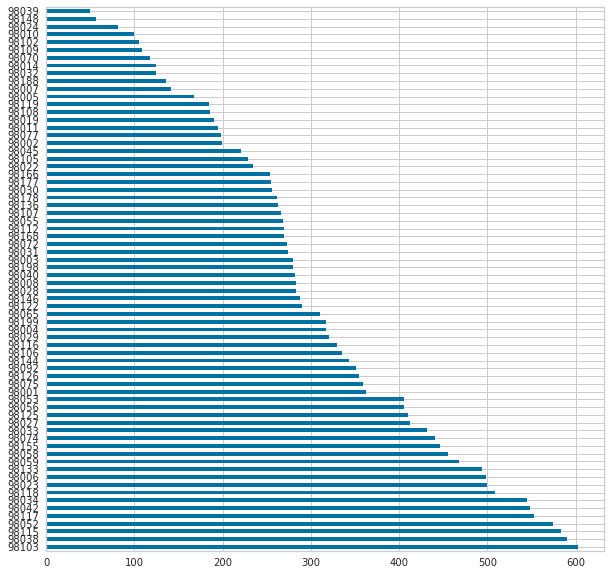

In [154]:
fig = house_eda["zipcode"].value_counts().plot(kind='barh', figsize = (10, 10))
plt.show()

Due to the extremely high cardinality of zipcode, it is likely useless unless we are able to do feature engineering on it. 

Numerical and Categorical Features

In [8]:
numerical_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']
geographical_features = ['lat', 'long']
categorical_features = ['waterfront', 'view', 'condition', 'grade']
target = 'price'

### Checking Data Distributions

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


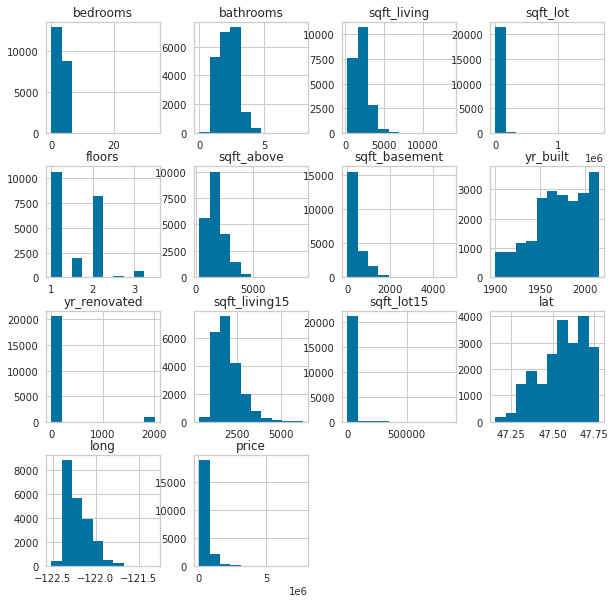

In [9]:
fig = house_eda[numerical_features + geographical_features + ['price']].hist(figsize=(10, 10))
plt.show()

- As suspected, most of the variables are positively skewed. 
- Price appears to follow a log normal distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


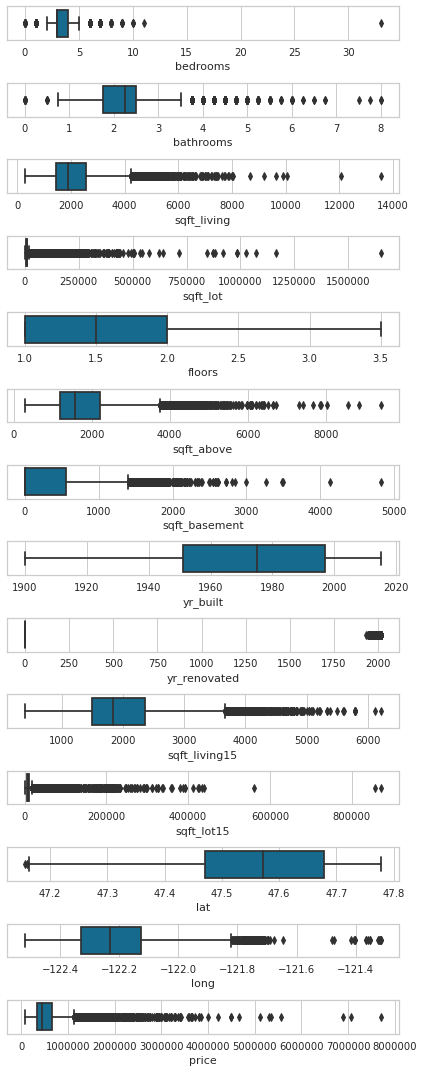

In [10]:
fig, ax = plt.subplots(len(numerical_features + geographical_features + ['price']), 1, figsize=(6, 15), tight_layout = True)

for idx, col in enumerate(numerical_features + geographical_features + ['price']):
    ax[idx].ticklabel_format(useOffset=False, style='plain') # do not use scientific notation
    sns.boxplot(data = house_eda, x=col, ax = ax[idx])
fig.show()

These numerical columns have many outliers:
- sqft_living
- sqft_lot
- sqft_above
- sqft_basement
- yr_renovated
- long
- sqft_living15
- sqft_lot15
- price

These columns contain fewer outliers:
- Bedrooms
- Bathrooms

Almost all numerical columns are positively skewed, with the exception of year built (most houses were built more recently)

Since the target variable has many outliers, any model we utilize should be robust to outliers.

### What do the distributions look like with outliers removed?

In [21]:

def outlierDetection(df : DataFrame, var : str, sort : bool = True) -> DataFrame:
    """
    Utilty function for detecting basic outliers. Prints out no. of outliers, shows first 5 outliers and displays a box plot. Outliers are defined in this case by Tukey's fences, where outliers are data points above or below the upper or lower quantiles by 1.5 * IQR.

    Parameters:
        df = DataFrame to detect outliers in
        var = name of column where outlier detection is performed
        sort = should the returned dataset be sorted?
    Returns:
        Dataset which only includes outliers
    """
    Q3 = df[var].quantile(0.75)
    Q1 = df[var].quantile(0.25)
    IQR = Q3 - Q1
    UpperFence = Q3 + 1.5 * IQR
    LowerFence = Q1 - 1.5 * IQR
    mask = (df[var] > UpperFence) | (df[var] < LowerFence)
    outlier_df = df[mask]
    if len(outlier_df) == 0:
        print("No Outliers")
    else:
        print("Outliers in Series (First 5)")
        print(outlier_df.head())
        print("No. of Outliers:", len(outlier_df))
    sns.boxplot(y = var,data = df, orient= "h")
    sns.despine(left = True)
    plt.title(f"Box Plot of {var}")
    plt.show()
    if sort:
        return outlier_df.sort_values(var)
    else:
        return outlier_df

In [19]:
def removeOutliers(data: Union[DataFrame, Series], cols : Union[List[str], None] = None) -> DataFrame:
    df_type = type(data)
    assert df_type is DataFrame or df_type is Series, "data should either be a pandas dataframe or series"
    assert cols is None or type(cols) is list, "Either provide None, or a list of col names"
    if cols is not None:
        data = data[cols]
    Q3 = data.quantile(0.75)
    Q1 = data.quantile(0.25)
    IQR = Q3 - Q1
    print("Shape Before Removing Outliers:", data.shape)
    data = data[~((data < (Q1 - (1.5 * IQR))) | (data > (Q3 + (1.5 * IQR)))).any(axis=1)]
    print("Shape After Removing Outliers:", data.shape)
    return data

Outliers in Series (First 5)
             id             date      price  bedrooms  bathrooms  sqft_living  \
5    7237550310  20140512T000000  1225000.0         4       4.50         5420   
21   2524049179  20140826T000000  2000000.0         3       2.75         3050   
49    822039084  20150311T000000  1350000.0         3       2.50         2753   
69   1802000060  20140612T000000  1325000.0         5       2.25         3200   
125  4389200955  20150302T000000  1450000.0         4       2.75         2750   

     sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
5      101930     1.0           0     0  ...     11        3890   
21      44867     1.0           0     4  ...      9        2330   
49      65005     1.0           1     2  ...      9        2165   
69      20158     1.0           0     0  ...      8        1600   
125     17789     1.5           0     0  ...      8        1980   

     sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
5       

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


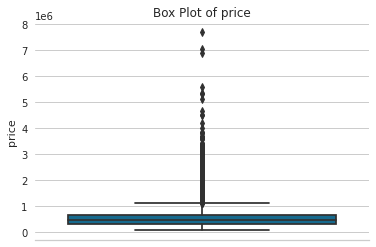

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3103,6613000015,20141223T000000,1130000.0,4,3.00,3180,4649,2.0,0,0,...,9,2070,1110,1925,0,98105,47.6583,-122.273,2720,5980
20729,3758900023,20140521T000000,1130000.0,4,3.25,3810,8519,1.0,0,1,...,10,2680,1130,2007,0,98033,47.6990,-122.207,3240,10748
11037,3860400060,20140801T000000,1130000.0,4,2.50,2660,11200,2.0,0,0,...,9,2660,0,1999,0,98004,47.5894,-122.197,3290,11275
11927,3528000310,20150427T000000,1130000.0,5,2.50,4310,28008,2.0,0,0,...,10,4310,0,1988,0,98053,47.6662,-122.056,3170,28559
4623,2581900165,20141021T000000,1130000.0,4,3.50,4300,8406,2.0,0,1,...,11,3580,720,1987,0,98040,47.5396,-122.214,2770,10006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,8907500070,20150413T000000,5350000.0,5,5.00,8000,23985,2.0,0,4,...,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
4411,2470100110,20140804T000000,5570000.0,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
9254,9208900037,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
3914,9808700762,20140611T000000,7062500.0,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449


In [22]:
outlierDetection(house_eda, "price") # Take a look at which houses have outlier prices

Among the outlier priced houses, we note:
- Sorted by price, the lowest price outlier house is around 1.1 million dollars. 

Shape Before Removing Outliers: (21613, 1)
Shape After Removing Outliers: (20467, 1)


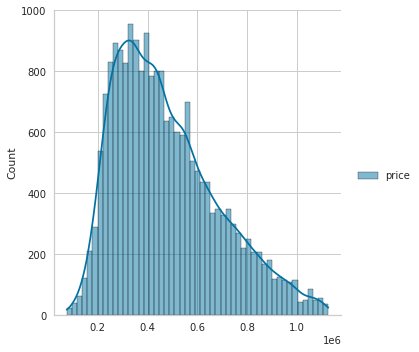

In [28]:
sns.displot(removeOutliers(house_eda, ["price"]), kde=True)

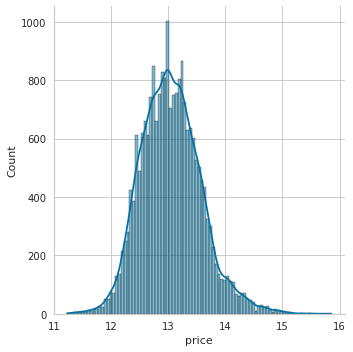

In [30]:
sns.displot(house_eda["price"].apply(np.log), kde=True)

As suspected, price data more closely follows a log-normal distribution.

### Distribution of Count Data

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

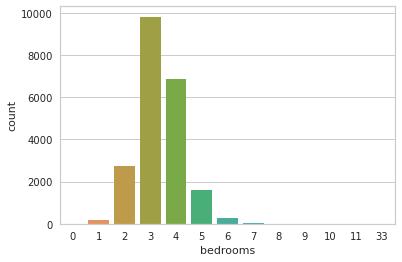

In [158]:
sns.countplot(data=house_eda, x="bedrooms")

For bathrooms, how many toilets and how many full sized bathrooms are there?

In [159]:
house_eda["bathrooms"].value_counts()

2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
8.00       2
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

- There are some houses without even a toilet (10 of them in the dataset)

Since 0.25 of a bathroom is a toilet only, let's see how many toilets and full bathrooms there are

In [160]:
house_eda["full_bathrooms"] = house_eda["bathrooms"].apply(lambda x : np.floor(x))
house_eda["toilets_only"] = (house_eda["bathrooms"] - house_eda["full_bathrooms"]) / 0.25

<AxesSubplot:xlabel='full_bathrooms', ylabel='count'>

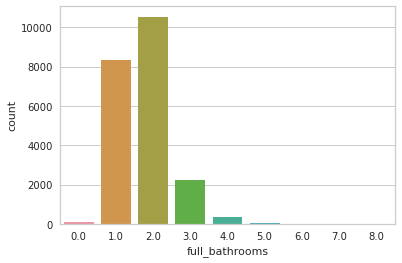

In [161]:
sns.countplot(data=house_eda, x="full_bathrooms")

- Most houses have two or one full bathrooms (including toilet)
- It is very rare for a house to have no full bathrooms or five. 

<AxesSubplot:xlabel='toilets_only', ylabel='count'>

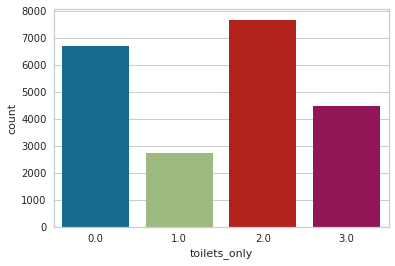

In [162]:
sns.countplot(data=house_eda, x="toilets_only")


Most households have either two rooms that are just toilets, or no rooms that are toilets only.

### Where are the outliers?
- Outlier value for bedrooms (>30 bedrooms in a single house)
- Outlier house sizes for both living space and lot size.
- Bathrooms has quarter values. 
- 0 values for square footage of above and basement (does not exist?)
- Around 50% houses were built between the 1950s and 1990s
- Most houses have never been renovated; Is the fact that they are renovated more important than the actual year of renovation? 
- Outlier prices (> 1million USD)

The presence of outliers, especially in the price, indicates that any feature scaling and model done should be robust to outliers.

### Categorical Data Distribution
- With the exception of waterfront, most categorical variables are ordinal variables.

<AxesSubplot:xlabel='waterfront', ylabel='count'>

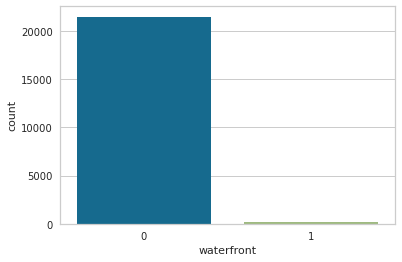

In [163]:
sns.countplot(data=house_eda, x="waterfront")

<AxesSubplot:xlabel='view', ylabel='count'>

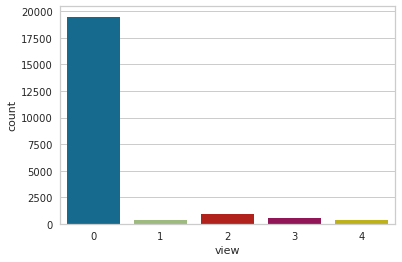

In [164]:
sns.countplot(data=house_eda, x="view")

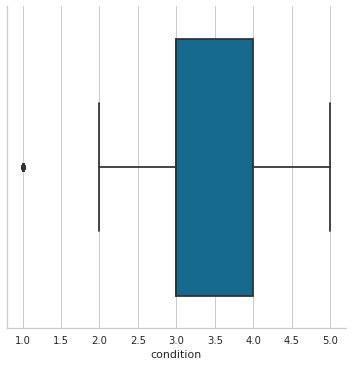

In [165]:
sns.catplot(data=house_eda, x="condition", kind='box')

<AxesSubplot:xlabel='grade', ylabel='count'>

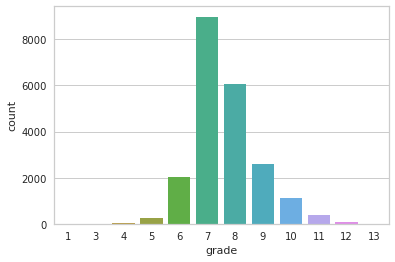

In [166]:
sns.countplot(data=house_eda, x="grade")

Most houses are of grade 7, followed by grade 8 and 9.

### Checking for Missing Values
While initially it seems that there are no missing values, is that actually the case? or have missing values been pre-filled with some value like 0?

In [167]:
house_eda.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view              0
condition         0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
yr_renovated      0
zipcode           0
lat               0
long              0
sqft_living15     0
sqft_lot15        0
full_bathrooms    0
toilets_only      0
dtype: int64

In [168]:
(house_eda[numerical_features].apply(lambda x : x == 0).sum() / len(house_eda)) * 100

bedrooms          0.060149
bathrooms         0.046268
sqft_living       0.000000
sqft_lot          0.000000
floors            0.000000
sqft_above        0.000000
sqft_basement    60.731967
yr_built          0.000000
yr_renovated     95.771064
sqft_living15     0.000000
sqft_lot15        0.000000
dtype: float64

- Houses without basements will have 0 area for basement. Hence missing values for sqft_basement are missing systematically
- Similar logic goes for yr_renovated
- However, it seems unlikely that there would be houses without any bedrooms nor bathrooms

In [53]:
house_eda[house_eda["bedrooms"] == 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,has_basement
875,6306400140,2014-06-12,1095000.0,0,0.00,3064,4764,3.5,0,2,...,0,1990,0,98102,47.6362,-122.322,2360,4000,False,False
3119,3918400017,2015-02-05,380000.0,0,0.00,1470,979,3.0,0,2,...,0,2006,0,98133,47.7145,-122.356,1470,1399,False,False
3467,1453602309,2014-08-05,288000.0,0,1.50,1430,1650,3.0,0,0,...,0,1999,0,98125,47.7222,-122.290,1430,1650,False,False
4868,6896300380,2014-10-02,228000.0,0,1.00,390,5900,1.0,0,0,...,0,1953,0,98118,47.5260,-122.261,2170,6000,False,False
6994,2954400190,2014-06-24,1295650.0,0,0.00,4810,28008,2.0,0,0,...,0,1990,0,98053,47.6642,-122.069,4740,35061,False,False
8477,2569500210,2014-11-17,339950.0,0,2.50,2290,8319,2.0,0,0,...,0,1985,0,98042,47.3473,-122.151,2500,8751,False,False
8484,2310060040,2014-09-25,240000.0,0,2.50,1810,5669,2.0,0,0,...,0,2003,0,98038,47.3493,-122.053,1810,5685,False,False
9773,3374500520,2015-04-29,355000.0,0,0.00,2460,8049,2.0,0,0,...,0,1990,0,98031,47.4095,-122.168,2520,8050,False,False
9854,7849202190,2014-12-23,235000.0,0,0.00,1470,4800,2.0,0,0,...,0,1996,0,98065,47.5265,-121.828,1060,7200,False,False
12653,7849202299,2015-02-18,320000.0,0,2.50,1490,7111,2.0,0,0,...,0,1999,0,98065,47.5261,-121.826,1500,4675,False,False


In [54]:
house_eda[house_eda["bathrooms"] == 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,has_basement
875,6306400140,2014-06-12,1095000.0,0,0.0,3064,4764,3.5,0,2,...,0,1990,0,98102,47.6362,-122.322,2360,4000,False,False
1149,3421079032,2015-02-17,75000.0,1,0.0,670,43377,1.0,0,0,...,0,1966,0,98022,47.2638,-121.906,1160,42882,False,False
3119,3918400017,2015-02-05,380000.0,0,0.0,1470,979,3.0,0,2,...,0,2006,0,98133,47.7145,-122.356,1470,1399,False,False
5832,5702500050,2014-11-04,280000.0,1,0.0,600,24501,1.0,0,0,...,0,1950,0,98045,47.5316,-121.749,990,22549,False,False
6994,2954400190,2014-06-24,1295650.0,0,0.0,4810,28008,2.0,0,0,...,0,1990,0,98053,47.6642,-122.069,4740,35061,False,False
9773,3374500520,2015-04-29,355000.0,0,0.0,2460,8049,2.0,0,0,...,0,1990,0,98031,47.4095,-122.168,2520,8050,False,False
9854,7849202190,2014-12-23,235000.0,0,0.0,1470,4800,2.0,0,0,...,0,1996,0,98065,47.5265,-121.828,1060,7200,False,False
10481,203100435,2014-09-18,484000.0,1,0.0,690,23244,1.0,0,0,...,0,1948,0,98053,47.6429,-121.955,1690,19290,False,False
14423,9543000205,2015-04-13,139950.0,0,0.0,844,4269,1.0,0,0,...,0,1913,0,98001,47.2781,-122.250,1380,9600,False,False
19452,3980300371,2014-09-26,142000.0,0,0.0,290,20875,1.0,0,0,...,0,1963,0,98024,47.5308,-121.888,1620,22850,False,False


<AxesSubplot:xlabel='long', ylabel='lat'>

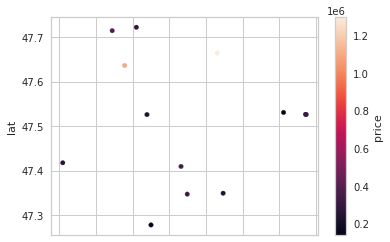

In [59]:
house_eda[house_eda["bedrooms"] == 0].plot(kind='scatter', x='long', y='lat', c='price', cmap='rocket')

- House in row 875 seems suspicious, given it is so big, has such a high price, yet has no bedrooms and bathrooms. It is likely to be a result of data entry error.
- The other houses seem suspicious as well, and it may be better if these houses are removed, since they only make up an extremely small percentage of the data.

### Is there any relationship between the age of the house and the price?

In [171]:
house_eda["age"] = house_eda["date"].dt.year - house_eda["yr_built"]
house_eda["age"]

0        59
1        63
2        82
3        49
4        28
         ..
21608     5
21609     1
21610     5
21611    11
21612     6
Name: age, Length: 21613, dtype: int64

<AxesSubplot:xlabel='age'>

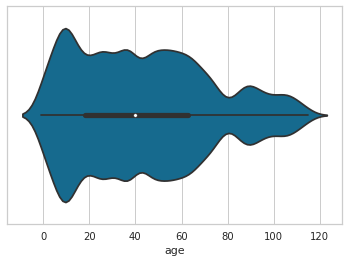

In [172]:
sns.violinplot(x='age', data=house_eda)

Most houses are between 20 and 60 years of age. The distribution of age is positively skewed, with a few houses being very old (>100 years old)

<AxesSubplot:xlabel='age', ylabel='price'>

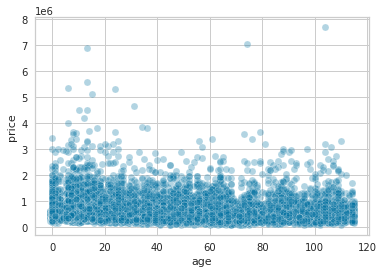

In [173]:
sns.scatterplot(x='age',y='price', data=house_eda, alpha=0.3)

The relationship between age and price appears to be very weak. We note that younger houses tend to have more outlier prices, however the highest priced house is over a hundred years old.

### Is it more important that a house has been renovated, than when it was renovated?

<AxesSubplot:xlabel='yr_renovated', ylabel='price'>

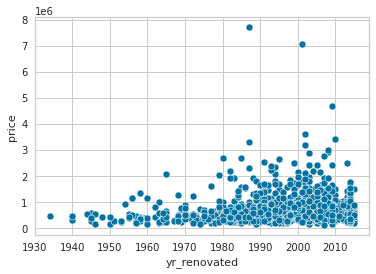

In [34]:
sns.scatterplot(x='yr_renovated', y='price', data=house_eda[house_eda["yr_renovated"] != 0])

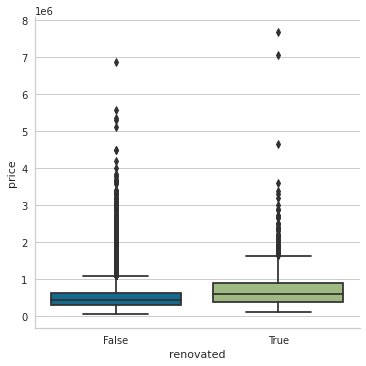

In [49]:
house_eda["renovated"] = house_eda["yr_renovated"] != 0
sns.catplot(x="renovated", y="price", data=house_eda, kind="box")

### Is it more important that a basement exists, than the size of the basement?

<AxesSubplot:xlabel='sqft_basement', ylabel='price'>

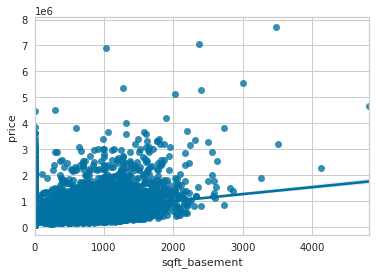

In [43]:
sns.regplot(x='sqft_basement', y='price', data=house_eda)

<AxesSubplot:xlabel='sqft_basement', ylabel='price'>

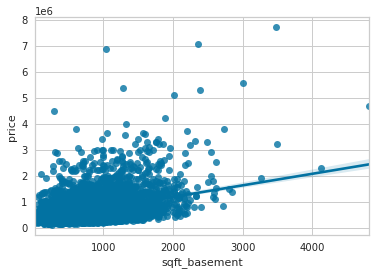

In [42]:
sns.regplot(x='sqft_basement', y='price', data=house_eda[house_eda["sqft_basement"] != 0])

In [44]:
house_eda["has_basement"] = house_eda["sqft_basement"] != 0

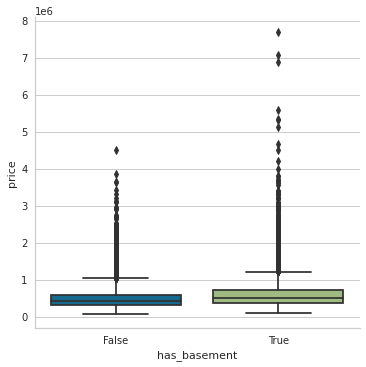

In [48]:
sns.catplot(x="has_basement", y="price", data=house_eda, kind="box")

Due to the overlap between the two categories, there is little evidence to suggest a significant difference between houses with and without basements.

### Geographical Data

<AxesSubplot:xlabel='long', ylabel='lat'>

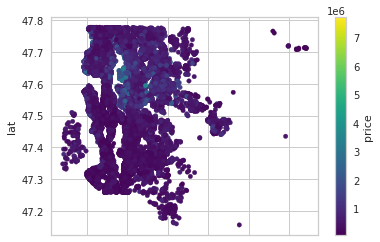

In [174]:
house_eda.plot(x='long', y='lat', kind='scatter', c='price', cmap='viridis')

The points to the west are centered in the city of Seattle, Renton, Vashon Island

Note that the areas near Lake Washington and Lake Sammamish seem to have a higher value

<AxesSubplot:xlabel='long', ylabel='lat'>

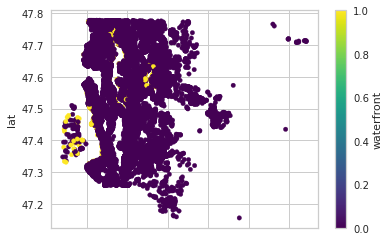

In [175]:
house_eda.plot(x='long', y='lat', kind='scatter', c='waterfront', cmap='viridis')

Despite that, only properties very close to the water are marked as waterfront properties. It seems from our previous plot that even properties not next to the water, but close, benefit from higher prices. This suggests we could engineer a feature based on proximity to waterfront houses, or do clustering to extract more info from the location.

Since Latitute and Longitude represent points on a sphere, clustering distance metric should use [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula), which uses latitude and longitude to get the spherical distance.


In [62]:
house_eda["x"] = house_eda["lat"].apply(np.cos) * house_eda["long"].apply(np.cos)
house_eda["y"] = house_eda["lat"].apply(np.cos) * house_eda["long"].apply(np.sin)
house_eda["z"] =  house_eda["lat"].apply(np.sin) 

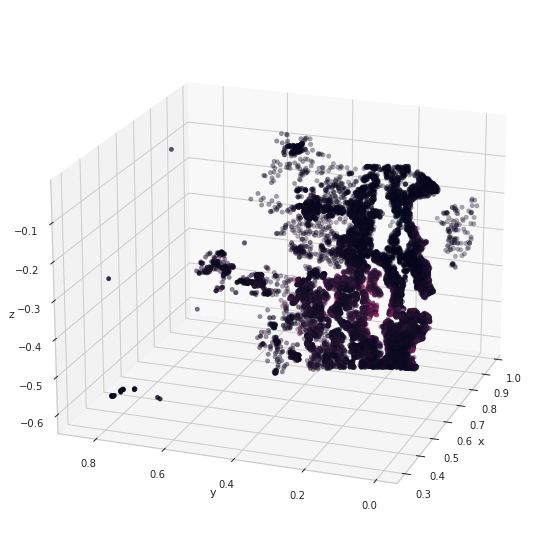

In [99]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(house_eda["x"], house_eda["y"], house_eda["z"], c=house_eda["price"], cmap="rocket")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20, 200)

In [177]:
# test["x"] = test[0].apply(lambda x : x[0])
# test["y"] = test[0].apply(lambda x : x[1])
# test["z"] = test[0].apply(lambda x : x[2])
# test.plot(x='x', y='y', kind='scatter')

### What are the relationships between the variables?

In [93]:
house_corr = house_eda.drop(['id', 'zipcode', 'date'], axis=1).corr().abs()

In [94]:
cols = house_corr.sort_values('price', ascending=False)
cols

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,lat,long,sqft_living15,sqft_lot15,renovated,has_basement,x,y,z
price,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,...,0.126434,0.307003,0.021626,0.585379,0.082447,0.126092,0.180230,0.222993,0.013748,0.312969
sqft_living,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,0.058753,0.762704,...,0.055363,0.052529,0.240223,0.756420,0.183286,0.055094,0.204495,0.176301,0.229304,0.054641
grade,0.667434,0.356967,0.664983,0.762704,0.113621,0.458183,0.082775,0.251321,0.144674,1.000000,...,0.014414,0.114084,0.198372,0.713202,0.119248,0.014008,0.051838,0.196783,0.180736,0.116677
sqft_above,0.605567,0.477600,0.685342,0.876597,0.183512,0.523885,0.072075,0.167649,0.158214,0.755923,...,0.023285,0.000816,0.343803,0.731870,0.194050,0.023178,0.210991,0.210117,0.335858,0.000209
sqft_living15,0.585379,0.391638,0.568634,0.756420,0.144608,0.279885,0.086463,0.280439,0.092824,0.713202,...,0.002673,0.048858,0.334605,1.000000,0.183192,0.002755,0.043830,0.227839,0.322572,0.050864
bathrooms,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,0.124982,0.664983,...,0.050739,0.024573,0.223042,0.568634,0.087175,0.050260,0.163534,0.149053,0.217345,0.026232
view,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,...,0.103917,0.006157,0.078400,0.280439,0.072575,0.104062,0.181808,0.043515,0.077871,0.008150
sqft_basement,0.323816,0.303093,0.283770,0.435043,0.015286,0.245705,0.080588,0.276947,0.174105,0.168392,...,0.071323,0.110538,0.144765,0.200355,0.017276,0.070963,0.819152,0.027282,0.152558,0.113001
z,0.312969,0.008350,0.026232,0.054641,0.088047,0.051836,0.013420,0.008150,0.015075,0.116677,...,0.030356,0.999543,0.134435,0.050864,0.089182,0.030302,0.141170,0.689861,0.266368,1.000000
bedrooms,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,0.006582,0.079532,0.028472,0.356967,...,0.018841,0.008931,0.129473,0.391638,0.029244,0.018553,0.163471,0.052858,0.132254,0.008350


<AxesSubplot:>

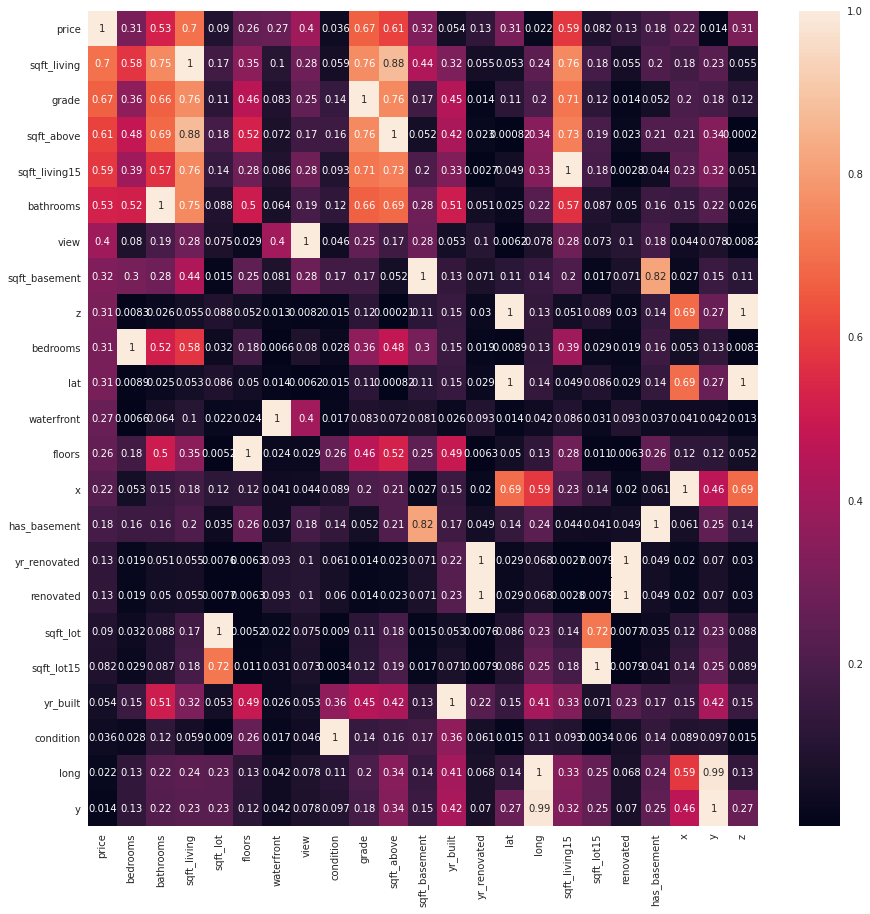

In [95]:
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(cols, annot=True)

#### Pearson Correlation Plot Interpretation
- Relationship of Lot Size with Price is extremely weak. In contrast, size of the living space has the heighest correlation with the price of the house
- Grade (quality of house) has a strong correlation with the price.
- It seems that elevation above the ground has higher correlation with price than latitude

### Initial Data Preprocessing

#### Feature Selection
- Uninformative columns are dropped

#### Feature Engineering
- Convert latitude and longitude to x, y, z coordinates

#### Numerical Data
- Robust Scaling is used using Median and IQR instead of Mean and STD given that most features have many outliers.

#### Categorical Data
- Data has already been properly encoded, so no preprocessing is actually required here.

In [100]:
house_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [145]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
categorical_features = ['waterfront', 'view', 'condition', 'grade']
geographical_features = ['lat', 'long']
numerical_features = list(set(features) - set(categorical_features) - set(geographical_features))
X, y = house_df[features], house_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)

In [132]:
class LatLongTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_latlong: bool = True, df_cols = geographical_feautures):
        self.drop_latlong = drop_latlong
        self.df_cols = df_cols
    def fit(self, X, y = None):
        return self
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=geographical_features)
        df["x"] = df["lat"].apply(np.cos) * df["long"].apply(np.cos)
        df["y"] = df["lat"].apply(np.cos) * df["long"].apply(np.sin)
        df["z"] =  df["lat"].apply(np.sin) 
        if self.drop_latlong:
            df.drop(["lat", "long"], axis = 1, inplace=True)
        return df

In [146]:
lt = LatLongTransformer()
lt.transform(X[geographical_features])

,x,y,z
0,0.893579,0.242611,-0.377699
1,0.809964,0.166815,-0.562255
2,0.783422,0.233027,-0.576150
3,0.914583,0.118746,-0.386571
4,0.782578,0.404552,-0.473192
...,...,...,...
21608,0.825992,0.146991,-0.544179
21609,0.914271,0.147651,-0.377236
21610,0.869244,0.197223,-0.453341
21611,0.824354,0.401379,-0.399169


In [151]:
numerical_transformers = Pipeline([
    ('Feature Scaling', RobustScaler())
#     ('Imputation', SimpleImputer())
])

geographical_transformers = Pipeline([
    ('Convert Lat and Long', LatLongTransformer()),
    ('Feature Scaling', RobustScaler())
]) 

# categorical_transformers = Pipeline([
#     ('Imputation', SimpleImputer())
# ])

data_preprocessing_transformer = ColumnTransformer([
    ('Numerical Features', numerical_transformers, numerical_features),
    ('Categorical Features', 'passthrough', categorical_features),
    ('Geographical Features', geographical_transformers, geographical_features)
])

## Modelling

In [193]:
baseline = Pipeline([
    ('Data Preprocessing', data_preprocessing_transformer),
    ('Model', DummyRegressor())
])

linear_regression = Pipeline([
    ('Data Preprocessing', data_preprocessing_transformer),
    ('Model', LinearRegression())
])

## Model Evaluation
### Evaluation Metric
Due to the high amount of outliers in our prices, using a metric like Mean Squared Error or Root Mean Squared Error, which heavily penalises large errors, may not make much sense in telling us how good our model is at predicting the typical house.

Also, we avoid using $R^2$ as the $R^2$ score can be inflated when more variables are included.
#### Median Absolute Error
$$
MAE(y,\hat{y}) = median(|y_i - \hat{y}_i|\text{ for $i$ in 1, .., $n$})
$$

In [191]:
def evalCandidateModel(model, X_train, X_test, y_train, y_test, scoring = 'neg_mean_absolute_percentage_error', cv = 5, return_learning_curve = True):
    scores = cross_validate(model, X_train, y_train, scoring=scoring, return_estimator=True, return_train_score=True, cv=cv, n_jobs=-1)
    best_estimator = scores["estimator"][np.argmax(scores["test_score"])]
    del scores["estimator"]
    scores = pd.DataFrame(scores)
      # If a hold out set is provided
    if X_test is not None and y_test is not None:
        scorer = get_scorer(scoring) # Then also score it, based off the scoring scheme provided
        scores["hold_out_score"] = scorer(best_estimator, X_test, y_test)
    # If user wants to create a learning_curve
    if return_learning_curve:
        fig = learning_curve(model, X_train, y_train, scoring = scoring, n_jobs=-1, random_state = 42, cv =cv, show = False)
    else:
        fig = None # Else, return nothing
    return scores.describe().iloc[1:3, 2:].round(5), fig, model


In [117]:
def evalHistory(new_score, model_name, history = None):
    if history is None:
        history = pd.DataFrame()
    new_score =new_score.iloc[0, :]
    new_score.rename(index=model_name, inplace=True)
    history = history.append(new_score)
    return history

    

,test_score,train_score,hold_out_score
mean,-0.53288,-0.53287,-0.52813
std,0.00513,0.00099,0.00000


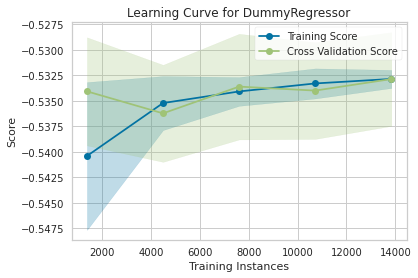

In [192]:
scores, fig, baseline = evalCandidateModel(baseline, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Baseline (Mean Predictor)")
scores

- A baseline model which predicts the mean price performs poorly. It has an MAE of \$185847.98


In [187]:
history

,hold_out_score,test_score,train_score
Baseline (Mean Predictor),-388964.9415,-360972.13534,-361421.29721


,test_score,train_score,hold_out_score
mean,-0.25601,-0.25562,-0.25174
std,0.00433,0.00241,0.00000


,hold_out_score,test_score,train_score
Baseline (Mean Predictor),-0.52813,-0.53288,-0.53287
Linear Regression,-0.25174,-0.25601,-0.25562


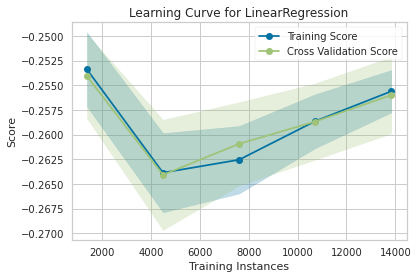

In [194]:
scores, fig, linear_regression = evalCandidateModel(linear_regression, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Linear Regression", history)
display(scores)
display(history)

- A baseline linear regression model using most of the features performs better (approx twice as good) than the baseline, with an MAE of around \$87522.32
- This model still suffers from high bias, as the model is nowhere close to a human level of performance.

### Next Steps
Now that we have a baseline, what are the issues identified?
- Regression algorithm has both high bias (due to high MAE on training set), and high variance (MAE on CV set is higher than the training set by a significant margin)
- In this case, the avoidable bias problem is more important due to the high MAE

We will take measures to deal with the bias and variance problem separately, starting with the bigger issue, the high model bias.

#### Ideas for Dealing with Avoidable Bias
- Try out other models such as Random Forests, which are non-parametric, and hence more robust to outliers
- Feature Engineering: During EDA, we identified that proximity to the waterfront alone is correlated with higher prices. Is it possible to engineer a distance metric or cluster metric?
- Since our price follows a log-normal distribution, might a log transformation of the target help our model?
- Deal with outliers
- Remove features with low correlation, as they may add noise to the data, potentially increasing bias of the model

#### Dealing with High Variance
- Perform feature selection
- Remove colinear features (calculate VIF score, then remove features with high VIF)

#### Random Forest

In [195]:
rf = Pipeline([
    ('Data Preprocessing', data_preprocessing_transformer),
    ('Model', RandomForestRegressor())
])

,test_score,train_score,hold_out_score
mean,-0.13173,-0.04976,-0.13197
std,0.00392,0.00037,0.00000


,hold_out_score,test_score,train_score
Baseline (Mean Predictor),-0.52813,-0.53288,-0.53287
Linear Regression,-0.25174,-0.25601,-0.25562
Random Forest,-0.13197,-0.13173,-0.04976


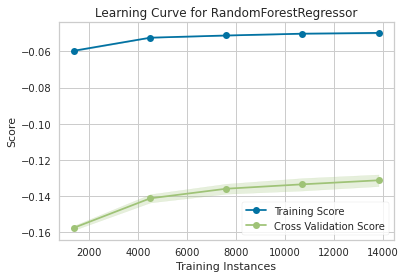

In [196]:
scores, fig, rf = evalCandidateModel(rf, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Random Forest", history)
display(scores)
display(history)

Random Forests greatly reduces the bias of the model, however, the model heavily overfits. We try to smooth out the variance by adding more trees to the random forest.

In [197]:
rf = Pipeline([
    ('Data Preprocessing', data_preprocessing_transformer),
    ('Model', RandomForestRegressor(n_estimators=500))
])

,test_score,train_score,hold_out_score
mean,-0.13078,-0.04907,-0.13106
std,0.00380,0.00025,0.00000


,hold_out_score,test_score,train_score
Baseline (Mean Predictor),-0.52813,-0.53288,-0.53287
Linear Regression,-0.25174,-0.25601,-0.25562
Random Forest,-0.13197,-0.13173,-0.04976
Random Forest (n_estimators = 500),-0.13106,-0.13078,-0.04907


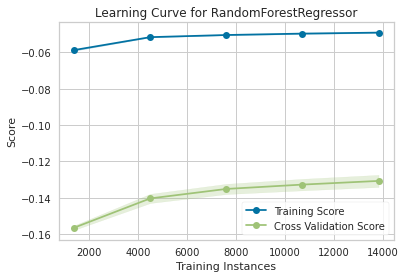

In [198]:
scores, fig, rf  = evalCandidateModel(rf, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Random Forest (n_estimators = 500)", history)
display(scores)
display(history)

Simply adding more trees does reduce the variance somewhat, but the decrease is small.

#### Gradient Boosting Trees

In [199]:
gbm = Pipeline([
    ('Data Preprocessing', data_preprocessing_transformer),
    ('Model', GradientBoostingRegressor())
])

,test_score,train_score,hold_out_score
mean,-0.14683,-0.14088,-0.14948
std,0.00295,0.00084,0.00000


,hold_out_score,test_score,train_score
Baseline (Mean Predictor),-0.52813,-0.53288,-0.53287
Linear Regression,-0.25174,-0.25601,-0.25562
Random Forest,-0.13197,-0.13173,-0.04976
Random Forest (n_estimators = 500),-0.13106,-0.13078,-0.04907
Gradient Boosting Trees,-0.14948,-0.14683,-0.14088


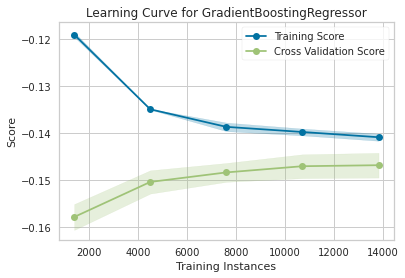

In [200]:
scores, fig, gbm  = evalCandidateModel(gbm, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Gradient Boosting Trees", history)
display(scores)
display(history)

With the default parameters, GBM's still appear to perform worse than Random Forests.

,test_score,train_score,hold_out_score
mean,-0.14038,-0.13388,-0.14155
std,0.00199,0.00046,0.00000


,hold_out_score,test_score,train_score
Baseline (Mean Predictor),-0.52813,-0.53288,-0.53287
Linear Regression,-0.25174,-0.25601,-0.25562
Random Forest,-0.13197,-0.13173,-0.04976
Random Forest (n_estimators = 500),-0.13106,-0.13078,-0.04907
Gradient Boosting Trees,-0.14948,-0.14683,-0.14088
Gradient Boosting Trees (Huber Loss),-0.14155,-0.14038,-0.13388


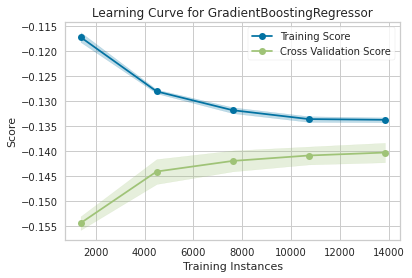

In [201]:
gbm = Pipeline([
    ('Data Preprocessing', data_preprocessing_transformer),
    ('Model', GradientBoostingRegressor(loss='huber'))
])
scores, fig, gbm  = evalCandidateModel(gbm, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Gradient Boosting Trees (Huber Loss)", history)
display(scores)
display(history)

,test_score,train_score,hold_out_score
mean,-0.12736,-0.11225,-0.12795
std,0.00161,0.00057,0.00000


,hold_out_score,test_score,train_score
Baseline (Mean Predictor),-0.52813,-0.53288,-0.53287
Linear Regression,-0.25174,-0.25601,-0.25562
Random Forest,-0.13197,-0.13173,-0.04976
Random Forest (n_estimators = 500),-0.13106,-0.13078,-0.04907
Gradient Boosting Trees,-0.14948,-0.14683,-0.14088
Gradient Boosting Trees (Huber Loss),-0.14155,-0.14038,-0.13388
Gradient Boosting Trees (huber loss and n_estimators=500),-0.12795,-0.12736,-0.11225


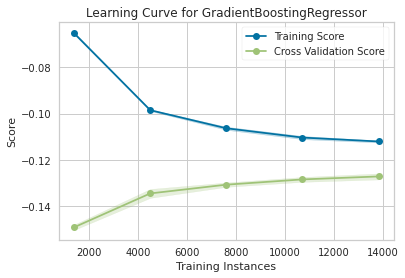

In [202]:
gbm = Pipeline([
    ('Data Preprocessing', data_preprocessing_transformer),
    ('Model', GradientBoostingRegressor(loss='huber', n_estimators=500))
])
scores, fig, gbm  = evalCandidateModel(gbm, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Gradient Boosting Trees (huber loss and n_estimators=500)", history)
display(scores)
display(history)

With some tweaks, GBM's can get better performance than RF on the CV set, making them viable models.

#### Target Transformation
In our EDA, we found that the target label, price, more closely follows a log-normal distribution than a normal distribution. Is it possible to improve performance by performing a log transformation on our target variable?

,test_score,train_score,hold_out_score
mean,-0.19758,-0.19717,-0.19912
std,0.00159,0.00034,0.00000


,hold_out_score,test_score,train_score
Baseline (Mean Predictor),-0.52813,-0.53288,-0.53287
Linear Regression,-0.25174,-0.25601,-0.25562
Random Forest,-0.13197,-0.13173,-0.04976
Random Forest (n_estimators = 500),-0.13106,-0.13078,-0.04907
Gradient Boosting Trees,-0.14948,-0.14683,-0.14088
Gradient Boosting Trees (Huber Loss),-0.14155,-0.14038,-0.13388
Gradient Boosting Trees (huber loss and n_estimators=500),-0.12795,-0.12736,-0.11225
Linear Regression (Log Transform on Price),-0.19912,-0.19758,-0.19717


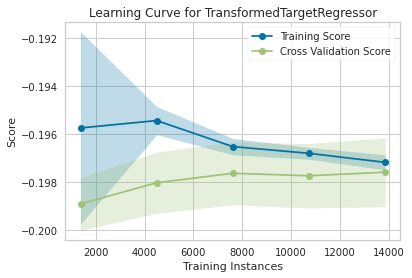

In [203]:
lr_log = TransformedTargetRegressor(linear_regression, func=np.log, inverse_func=np.exp)
scores, fig, lr_log  = evalCandidateModel(lr_log, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Linear Regression (Log Transform on Price)", history)
display(scores)
display(history)

The results for linear regression appear promising, as the target transformation manages to reduce the average MAE on k-fold CV by approx 19k. It is however, still unable to beat the random forests model.

In [204]:
rf_log = TransformedTargetRegressor(Pipeline([
    ('Data Preprocessing', data_preprocessing_transformer),
    ('Model', RandomForestRegressor())
]), func=np.log, inverse_func=np.exp)

,test_score,train_score,hold_out_score
mean,-0.12827,-0.04782,-0.12885
std,0.00313,0.00042,0.00000


,hold_out_score,test_score,train_score
Baseline (Mean Predictor),-0.52813,-0.53288,-0.53287
Linear Regression,-0.25174,-0.25601,-0.25562
Random Forest,-0.13197,-0.13173,-0.04976
Random Forest (n_estimators = 500),-0.13106,-0.13078,-0.04907
Gradient Boosting Trees,-0.14948,-0.14683,-0.14088
Gradient Boosting Trees (Huber Loss),-0.14155,-0.14038,-0.13388
Gradient Boosting Trees (huber loss and n_estimators=500),-0.12795,-0.12736,-0.11225
Linear Regression (Log Transform on Price),-0.19912,-0.19758,-0.19717
Random Forest (Log Transform on Price),-0.12885,-0.12827,-0.04782


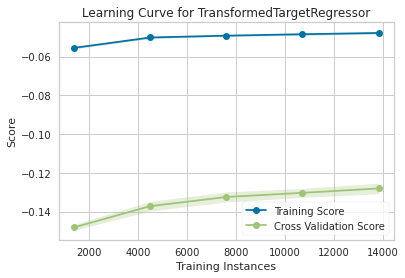

In [205]:
scores, fig, rf_log  = evalCandidateModel(rf_log, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Random Forest (Log Transform on Price)", history)
display(scores)
display(history)

The results for random forest are disappointing, as the model performance has remained largely the same.

,test_score,train_score,hold_out_score
mean,-0.13464,-0.12843,-0.13528
std,0.00191,0.00027,0.00000


,hold_out_score,test_score,train_score
Baseline (Mean Predictor),-0.52813,-0.53288,-0.53287
Linear Regression,-0.25174,-0.25601,-0.25562
Random Forest,-0.13197,-0.13173,-0.04976
Random Forest (n_estimators = 500),-0.13106,-0.13078,-0.04907
Gradient Boosting Trees,-0.14948,-0.14683,-0.14088
Gradient Boosting Trees (Huber Loss),-0.14155,-0.14038,-0.13388
Gradient Boosting Trees (huber loss and n_estimators=500),-0.12795,-0.12736,-0.11225
Linear Regression (Log Transform on Price),-0.19912,-0.19758,-0.19717
Random Forest (Log Transform on Price),-0.12885,-0.12827,-0.04782
GBM (Log Transform on Price),-0.13528,-0.13464,-0.12843


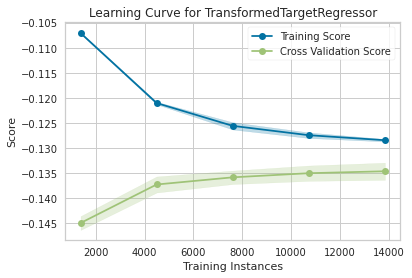

In [206]:
gbm_log = TransformedTargetRegressor(Pipeline([
    ('Data Preprocessing', data_preprocessing_transformer),
    ('Model', GradientBoostingRegressor())
]), func=np.log, inverse_func=np.exp)
scores, fig, gbm_log  = evalCandidateModel(gbm_log, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "GBM (Log Transform on Price)", history)
display(scores)
display(history)



GBM's seem to see greater improvements than RF when target is log-transformed. This suggests that GBM's may have more potential for improvement than RF models in this specific problem.

### Are X, Y, Z coordinates better predictors than Lat and Long?


,test_score,train_score,hold_out_score
mean,-0.13267,-0.05032,-0.13324
std,0.00438,0.00032,0.00000


,hold_out_score,test_score,train_score
Baseline (Mean Predictor),-0.52813,-0.53288,-0.53287
Linear Regression,-0.25174,-0.25601,-0.25562
Random Forest,-0.13197,-0.13173,-0.04976
Random Forest (n_estimators = 500),-0.13106,-0.13078,-0.04907
Gradient Boosting Trees,-0.14948,-0.14683,-0.14088
Gradient Boosting Trees (Huber Loss),-0.14155,-0.14038,-0.13388
Gradient Boosting Trees (huber loss and n_estimators=500),-0.12795,-0.12736,-0.11225
Linear Regression (Log Transform on Price),-0.19912,-0.19758,-0.19717
Random Forest (Log Transform on Price),-0.12885,-0.12827,-0.04782
GBM (Log Transform on Price),-0.13528,-0.13464,-0.12843


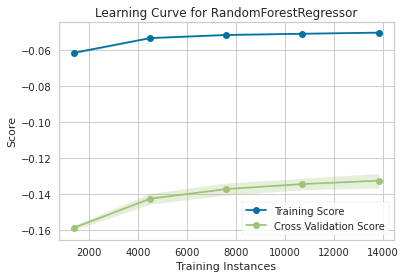

In [207]:
geographical_transformers_latlong = Pipeline([
#     ('Convert Lat and Long', LatLongTransformer()),
    ('Feature Scaling', RobustScaler())
]) 

# categorical_transformers = Pipeline([
#     ('Imputation', SimpleImputer())
# ])

data_preprocessing_transformer_latlong = ColumnTransformer([
    ('Numerical Features', numerical_transformers, numerical_features),
    ('Categorical Features', 'passthrough', categorical_features),
    ('Geographical Features', geographical_transformers_latlong, geographical_features)
])

rf_latlong = Pipeline([
    ('Data Preprocessing', data_preprocessing_transformer_latlong),
    ('Model', RandomForestRegressor())
])

scores, fig, rf_latlong  = evalCandidateModel(rf_latlong, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Random Forests (LatLong as it is)", history)
display(scores)
display(history)

Based off the higher MAPE in the CV set when using Lat and Long, it seems that the feature engineering we did
does help performance of our model.